# Co-occurnce and clustering
What dishes are mentioned together in the reviews? Do they form clusters? Can you identify cuisine types based on those clusters?

Data and Library importing

In [1]:
%load_ext autoreload
%autoreload 2

import json
from collections import defaultdict, Counter


#General-Purpose
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import shutil
import os
from tqdm import tqdm

#Preprocessing
#from utils.pipeline_v2b import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Clustering
from sklearn.cluster import KMeans, HDBSCAN, OPTICS

#Evaluation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_mutual_info_score

#Visualization
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#pandas and numpy for df manipulation
import pandas as pd
import re
import nltk
nltk.download('averaged_perceptron_tagger_eng')

#Preprocessing: tokenization
from nltk.tokenize import RegexpTokenizer

#NER and Metrics with sklearn and sklearn_crfsuite
from sklearn.model_selection import train_test_split
#%pip install git+"https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite"
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

#NER and Visualization with SpaCy
#%pip install -U pip setuptools wheel
#%pip install -U spacy
#!python -m spacy download en_core_web_sm
import spacy
from spacy import displacy
import sys
from nltk.corpus import wordnet

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
import pipeline as p

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
reviews = pd.read_csv(r'D:\MARGARIDA\dificuldade\3rd_year\TM project\Hyderabadi-Word-Soup\data_hyderabad\10k_reviews.csv')
restaurants = pd.read_csv(r'D:\MARGARIDA\dificuldade\3rd_year\TM project\Hyderabadi-Word-Soup\data_hyderabad\105_restaurants.csv')

## Applying Ner

### Pre Processing for NER

In [3]:
def regex_cleaner(raw_text, 
                  no_emojis = True, 
                  no_hashtags = True,
                  hashtag_retain_words = True,
                  no_newlines = True,
                  no_urls = True,
                  no_punctuation = True,
                  no_numbers = True):
    
    # Convert text to lowercase
    raw_text = raw_text.lower()
    
    newline_pattern = "(\\n)"
    hashtags_at_pattern = "([#\@@\u0040\uFF20\uFE6B])"
    hashtags_ats_and_word_pattern = "([#@]\w+)"
    emojis_pattern = "([\u2600-\u27FF])"
    url_pattern = "(?:\w+:\/{2})?(?:www)?(?:\.)?([a-z\d]+)(?:\.)([a-z\d\.]{2,})(\/[a-zA-Z\/\d]+)?" 
    punctuation_pattern = "[\u0021-\u0026\u0028-\u002C\u002E-\u002F\u003A-\u003F\u005B-\u005F\u2010-\u2028\ufeff`]+"
    apostrophe_pattern = "'(?=[A-Z\s])|(?<=[a-z\.\?\!\,\s])'"
    separated_words_pattern = "(?<=\w\s)([A-Z]\s){2,}"
    number_pattern = "[-+]?\d*\.?\d+"
    
    if no_emojis == True:
        clean_text = re.sub(emojis_pattern,"",raw_text)
    else:
        clean_text = raw_text

    if no_hashtags == True:
        if hashtag_retain_words == True:
            clean_text = re.sub(hashtags_at_pattern,"",clean_text)
        else:
            clean_text = re.sub(hashtags_ats_and_word_pattern,"",clean_text)
        
    if no_newlines == True:
        clean_text = re.sub(newline_pattern," ",clean_text)

    if no_urls == True:
        clean_text = re.sub(url_pattern,"",clean_text)
    
    if no_punctuation == True:
        clean_text = re.sub(punctuation_pattern,"",clean_text)
        clean_text = re.sub(apostrophe_pattern,"",clean_text)

    if no_numbers == True:
        clean_text = re.sub(number_pattern,"",clean_text)

    return clean_text

In [4]:
reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures', 'Rating'], axis=1, inplace=True)
reviews.dropna(subset=['Review'], inplace=True)

restaurants.drop(['Links', 'Cost', 'Collections', 'Timings'], axis=1, inplace=True)
restaurants.dropna(subset=['Name', 'Cuisines'], inplace=True)

# Merges the cuisines column with the reviews
reviews = reviews.merge(restaurants[['Name', 'Cuisines']], 
                                      left_on='Restaurant', right_on='Name', 
                                      how='left').drop(columns=['Name'])

reviews.drop(['Restaurant'], axis=1, inplace=True)

reviews.head()

,Review,Cuisines
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I..."
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I..."
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I..."
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I..."
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I..."


In [5]:
reviews["review_clean"] =\
      reviews["Review"].apply(lambda content :\
                                                  regex_cleaner(content))
reviews.head()

,Review,Cuisines,review_clean
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I...",ambience is too good for a pleasant evening se...
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I...",a must try great food great ambience thnx for ...
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I...",soumen das and arun was a great guy only becau...
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...


### Training and using a CRF model

Using a CRF model trained with external data

In [7]:
from nltk.corpus import treebank
treebank.words()

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', ...]

In [8]:
import nltk
import sklearn_crfsuite
from sklearn_crfsuite import metrics



# Load POS-tagged words from the Treebank Corpus
data = treebank.tagged_sents(tagset="universal")

# Feature extraction function
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],  # Last 3 letters
        'word[-2:]': word[-2:],  # Last 2 letters
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:  # Features for the previous word
        prev_word = sent[i - 1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:  # Features for the next word
        next_word = sent[i + 1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Convert sentences into feature representations
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for (word, label) in sent]

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X = [sent2features(s) for s in data]
y = [sent2labels(s) for s in data]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Initialize the CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # Coefficient for L1 regularization
    c2=0.1,  # Coefficient for L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)

# Train the model
crf.fit(X_train, y_train)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [10]:
y_pred = crf.predict(X_test)

# Evaluate with precision, recall, and F1 score
labels = list(crf.classes_)
print(metrics.flat_classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

        NOUN       0.96      0.98      0.97      5943
           .       1.00      1.00      1.00      2354
         NUM       1.00      0.98      0.99       727
         ADJ       0.89      0.84      0.86      1316
        VERB       0.96      0.96      0.96      2740
         DET       1.00      0.99      0.99      1795
         ADP       0.98      0.98      0.98      2028
        CONJ       1.00      0.99      0.99       471
        PRON       0.99      1.00      1.00       523
           X       1.00      0.99      0.99      1360
         ADV       0.93      0.93      0.93       634
         PRT       0.98      0.98      0.98       658

    accuracy                           0.97     20549
   macro avg       0.97      0.97      0.97     20549
weighted avg       0.97      0.97      0.97     20549



#### Predicting labels

Extracting features from the review_clean column

In [11]:
X_final = [sent2features(phrase) for phrase in reviews['review_clean']]

make predictions

In [12]:
reviews['predicted_pos_tags'] = crf.predict(X_final)
reviews

,Review,Cuisines,review_clean,predicted_pos_tags
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...,"[ADV, ADJ, NOUN, VERB, DET, NOUN, VERB, PRON, ..."
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I...",ambience is too good for a pleasant evening se...,"[DET, NOUN, VERB, PRON, VERB, ADJ, NOUN, NOUN,..."
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I...",a must try great food great ambience thnx for ...,"[DET, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN, NOUN..."
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I...",soumen das and arun was a great guy only becau...,"[ADV, ADJ, NOUN, NOUN, NOUN, NOUN, NOUN, VERB,..."
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...,"[ADV, ADJ, NOUN, NOUN, VERB, PRON, VERB, ADJ, ..."
...,...,...,...,...
9950,Madhumathi Mahajan Well to start with nice cou...,"Chinese, Seafood",madhumathi mahajan well to start with nice cou...,"[VERB, DET, NOUN, NOUN, NOUN, VERB, DET, NOUN,..."
9951,This place has never disappointed us.. The foo...,"Chinese, Seafood",this place has never disappointed us the food ...,"[ADV, VERB, PRON, VERB, ADJ, NOUN, VERB, DET, ..."
9952,"Bad rating is mainly because of ""Chicken Bone ...","Chinese, Seafood",bad rating is mainly because of chicken bone f...,"[VERB, DET, NOUN, NOUN, VERB, DET, ADJ, NOUN, ..."
9953,I personally love and prefer Chinese Food. Had...,"Chinese, Seafood",i personally love and prefer chinese food had ...,"[PRON, VERB, ADJ, NOUN, NOUN, NOUN, NOUN, VERB..."


Just from observing the resulting dataset, it is obvious that using it for the intended co-occurrence will not be possible due to the over bearing amout of nouns detected. As such, further analysis will be made using spacy

### Using spacy with Wordnet

Using spacy as a solution for Named Entity Recognition

In [7]:
#loading spacy 
nlp = spacy.load("en_core_web_sm")


In [8]:


def is_food(word):
    synsets = wordnet.synsets(word)
    for synset in synsets:
        if "food" in synset.lexname() or "edible" in synset.definition():
            return True
    return False

In [15]:
exclusion_list = ["food", "menu", "taste", "dishes", "dish", "table", "dinner", "lunch", "course", "ice", "drinks"]

def perform_ner_combined(text):
    '''
    Performs named entity recognition using Spacy. 
    Extracts unigrams and bigrams of noun tokens representing food names and combines them into a single list.
    args: 
        text (string) : text to perform the operation on
    returns:
        list of strings
    '''
    doc = nlp(text)
    
    # Extract noun tokens
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    
    # Create unigrams
    unigrams = [word for word in nouns if is_food(word.lower()) and word.lower() not in exclusion_list]
    
    # Create bigrams
    bigrams = [
        f"{word1} {word2}"
        for word1, word2 in zip(nouns[:-1], nouns[1:])
        if is_food(f"{word1} {word2}".lower()) and word1.lower() not in exclusion_list and word2.lower() not in exclusion_list
    ]
    
    # Combine unigrams and bigrams
    return unigrams + bigrams



In [16]:
reviews["filtered_review"] = reviews["review_clean"].apply(perform_ner_combined)

In [18]:
reviews

,Review,Cuisines,review_clean,filtered_review
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...,[brunch]
1,Ambience is too good for a pleasant evening. S...,"Chinese, Continental, Kebab, European, South I...",ambience is too good for a pleasant evening se...,[]
2,A must try.. great food great ambience. Thnx f...,"Chinese, Continental, Kebab, European, South I...",a must try great food great ambience thnx for ...,[]
3,Soumen das and Arun was a great guy. Only beca...,"Chinese, Continental, Kebab, European, South I...",soumen das and arun was a great guy only becau...,[]
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...,"[drumsticks, mutton, biryani]"
...,...,...,...,...
9950,Madhumathi Mahajan Well to start with nice cou...,"Chinese, Seafood",madhumathi mahajan well to start with nice cou...,"[spinach, meal, salad, cabbage, dressing, cabb..."
9951,This place has never disappointed us.. The foo...,"Chinese, Seafood",this place has never disappointed us the food ...,"[rice, oil, fish, noodles, chicken]"
9952,"Bad rating is mainly because of ""Chicken Bone ...","Chinese, Seafood",bad rating is mainly because of chicken bone f...,"[chicken, veg, luncheon, tables, veg, soup, sp..."
9953,I personally love and prefer Chinese Food. Had...,"Chinese, Seafood",i personally love and prefer chinese food had ...,[]


Although the results are not amazing, this is the model to be used in further analysis

## Co-occurence Analysis for dishes in reviews

In [19]:
def cooccurrence_matrix_window_generator(preproc_sentences, window_size):

    co_occurrences = defaultdict(Counter)

    # Compute co-occurrences
    for sentence in tqdm(preproc_sentences):
        for i, word in enumerate(sentence):
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    co_occurrences[word][sentence[j]] += 1

    #ensure that words are unique
    unique_words = list(set([word for sentence in preproc_sentences for word in sentence]))

    # Initialize the co-occurrence matrix
    co_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

    # Populate the co-occurrence matrix
    word_index = {word: idx for idx, word in enumerate(unique_words)}
    for word, neighbors in co_occurrences.items():
        for neighbor, count in neighbors.items():
            co_matrix[word_index[word]][word_index[neighbor]] = count

    # Create a DataFrame for better readability
    co_matrix_df = pd.DataFrame(co_matrix, index=unique_words, columns=unique_words)

    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=1)
    co_matrix_df = co_matrix_df.reindex(co_matrix_df.sum().sort_values(ascending=False).index, axis=0)

    # Return the co-occurrence matrix
    return co_matrix_df

In [20]:
reviews_food_co_occurence = cooccurrence_matrix_window_generator(reviews["filtered_review"].tolist(),1)

100%|██████████| 9955/9955 [00:00<00:00, 150187.75it/s]


In [21]:
reviews_food_co_occurence

,chicken,starters,rice,veg,fish,buffet,biryani,pizza,cheese,soup,...,lemonades,pulse,morsels,zombie,nutrition,draught,cracker,celery,port,calamari
chicken,510,115,161,51,113,21,139,69,47,81,...,0,0,0,0,0,0,0,0,0,0
starters,115,96,18,111,53,81,11,15,11,54,...,0,0,0,0,0,0,0,0,0,0
rice,161,18,108,29,18,4,47,3,3,9,...,0,0,0,0,0,0,0,0,0,0
veg,51,111,29,152,19,26,23,14,8,33,...,0,0,1,0,0,0,0,0,0,0
fish,113,53,18,19,98,10,7,10,4,11,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
draught,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cracker,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
celery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
port,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Visualising co-occurence

1 word context window

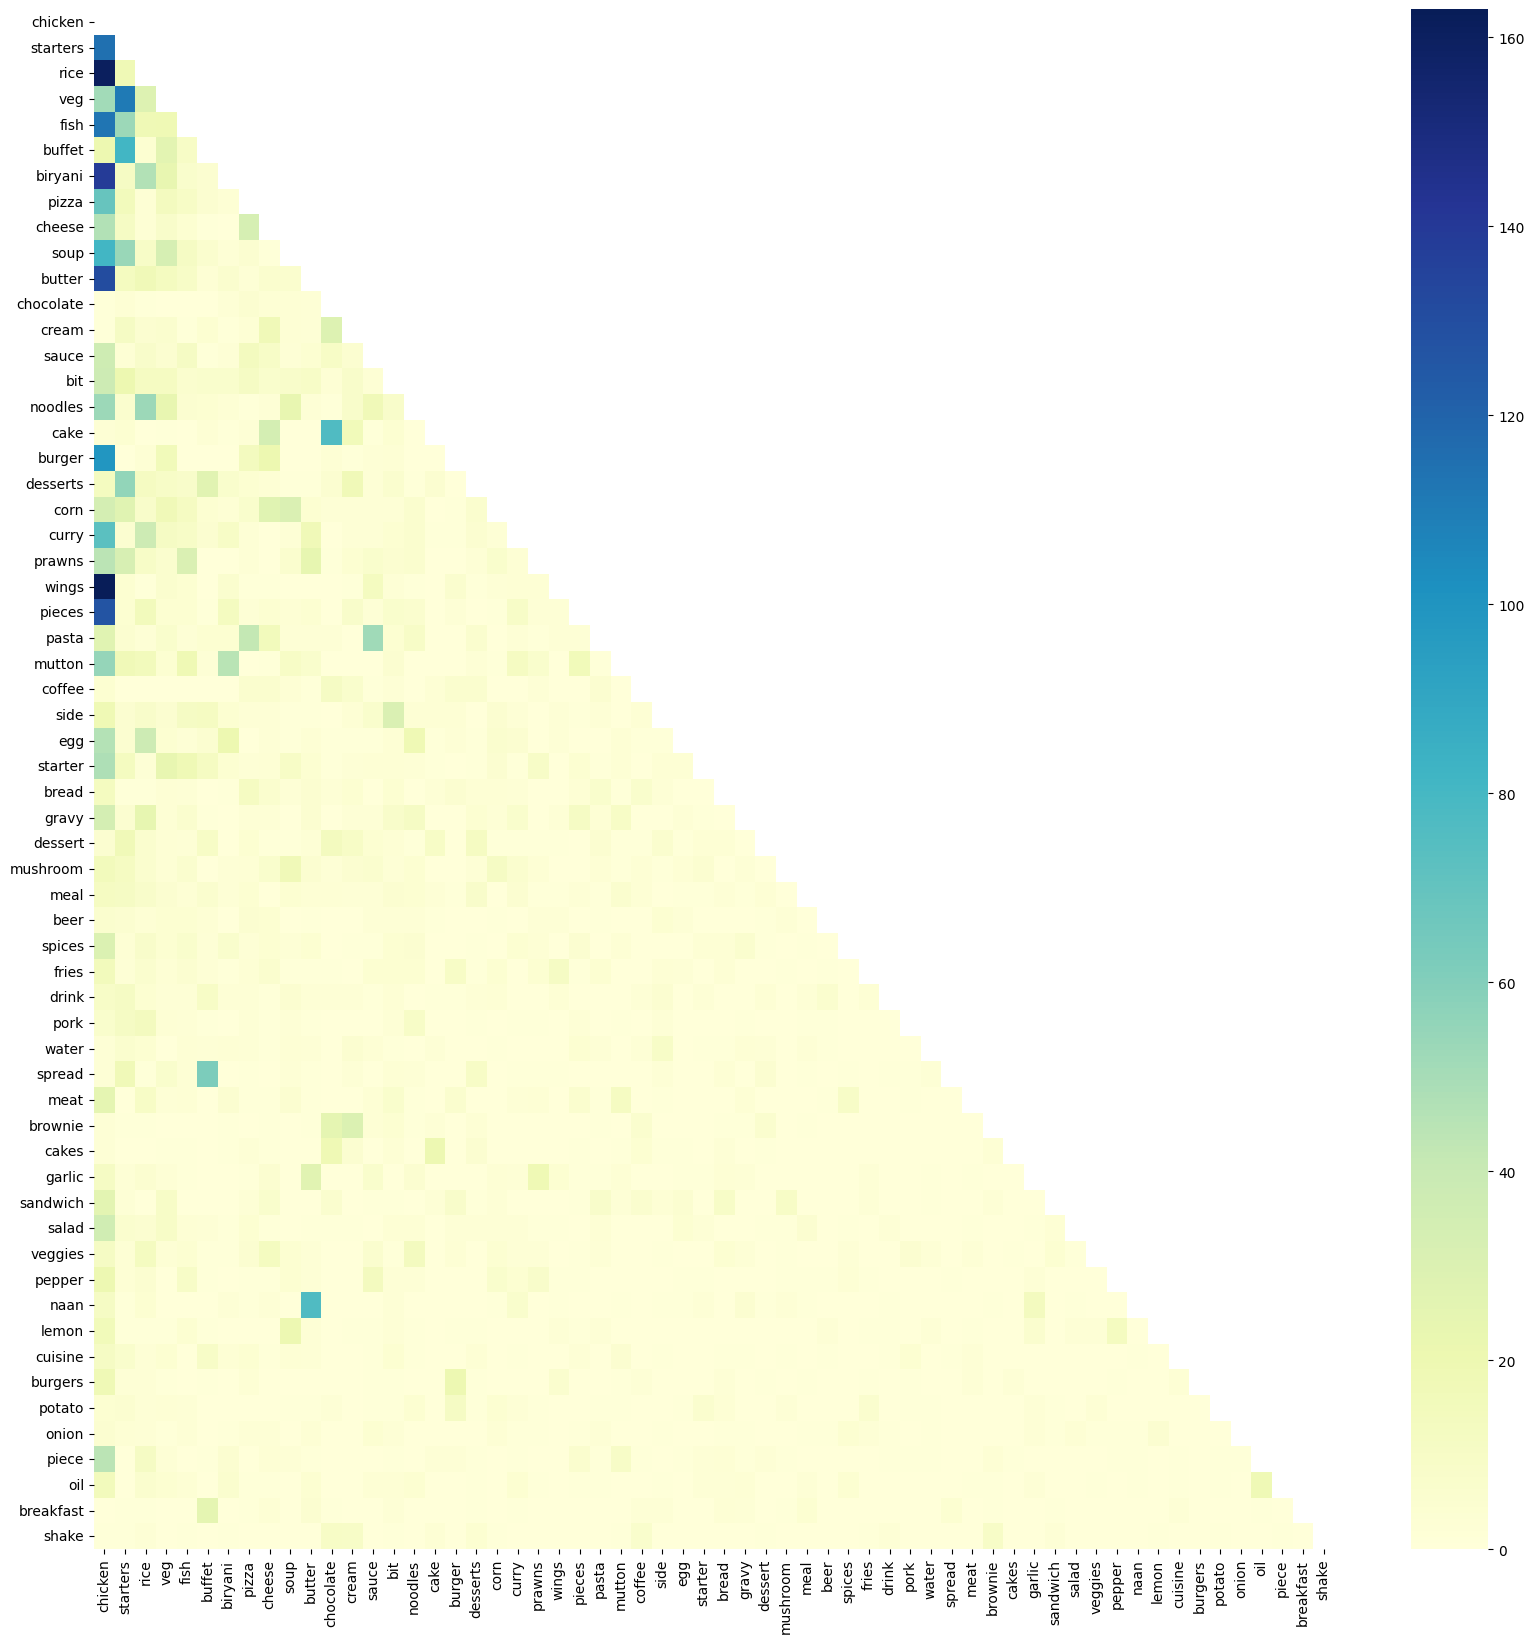

In [22]:
# Create a mask for the upper triangle, but leave the diagonal elements as True
mask = np.triu(np.ones_like(reviews_food_co_occurence.iloc[:60, :60], dtype=bool))

# Create heatmap from the co-occurrence matrix using 
plt.figure(figsize=(20,20))
sns.heatmap(reviews_food_co_occurence.iloc[:60, :60], cmap="YlGnBu", mask=mask)
plt.show()

2 word context window

In [23]:
reviews_food_co_occurence_2 = cooccurrence_matrix_window_generator(reviews["filtered_review"].tolist(),2)

fig = px.imshow(reviews_food_co_occurence_2.iloc[:60, :60], color_continuous_scale='YlGnBu', 
                labels=dict(x="Words", y="Words", color="Count"),
                title="Co-occurrence matrix (60 most frequent co-occurring words in a 2-token context window)", 
                width=1200, height=1200)

fig.show()


100%|██████████| 9955/9955 [00:00<00:00, 74011.05it/s]


#### Network graph

In [24]:
def cooccurrence_network_generator(cooccurrence_matrix_df, n_highest_words, output=None):
    
    filtered_df = cooccurrence_matrix_df.iloc[:n_highest_words, :n_highest_words]
    graph = nx.Graph()

    # Add nodes for words and set their sizes based on frequency
    for word in filtered_df.columns:
        graph.add_node(word, size=filtered_df[word].sum())

    # Add weighted edges to the graph based on co-occurrence frequency
    for word1 in filtered_df.columns:
        for word2 in filtered_df.columns:
            if word1 != word2:
                graph.add_edge(word1, word2, weight=filtered_df.loc[word1, word2])

    figure = plt.figure(figsize=(14, 12))

    # Generate positions for the nodes
    pos = nx.spring_layout(graph, k=0.5)

    # Calculate edge widths based on co-occurrence frequency
    edge_weights = [0.1 * graph[u][v]['weight'] for u, v in graph.edges()]

    # Get node sizes based on the frequency of words
    node_sizes = [data['size'] * 2 for _, data in graph.nodes(data=True)]

    # Create the network graph
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=node_sizes)
    nx.draw_networkx_edges(graph, pos, edge_color='gray', width=edge_weights)
    nx.draw_networkx_labels(graph, pos, font_weight='bold', font_size=12)

    plt.show() 

    if output=="return":
        return figure

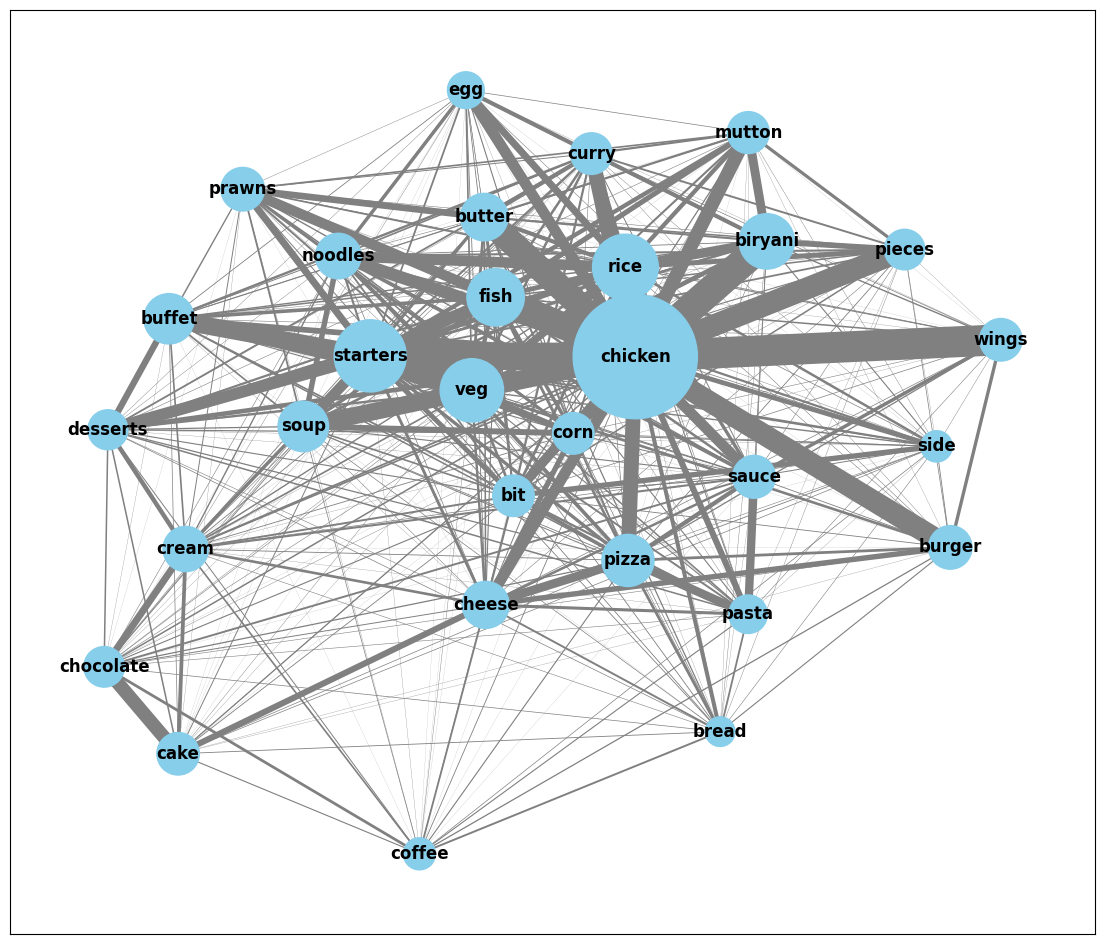

In [25]:
cooccurrence_network_generator(reviews_food_co_occurence_2, 30)

## Clustering

Using the dishes found in the reviews to try and create clusters based cuisine types.

### Preparing for clustering

Starting by removing any reviews that do not contain any dishes

In [26]:
reviews = reviews.loc[reviews['filtered_review'].apply(lambda x: len(x) > 0)]
reviews

,Review,Cuisines,review_clean,filtered_review
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...,[brunch]
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...,"[drumsticks, mutton, biryani]"
7,Well after reading so many reviews finally vis...,"Chinese, Continental, Kebab, European, South I...",well after reading so many reviews finally vis...,"[corn, fish, biryani]"
8,"Excellent food , specially if you like spicy f...","Chinese, Continental, Kebab, European, South I...",excellent food specially if you like spicy fo...,[dinners]
9,Came for the birthday treat of a close friend....,"Chinese, Continental, Kebab, European, South I...",came for the birthday treat of a close friend ...,"[treat, treat]"
...,...,...,...,...
9949,Chinese Pavilion in Banjara HIlls was the firs...,"Chinese, Seafood",chinese pavilion in banjara hills was the firs...,"[noodles, rice, lamb, brownie, rice]"
9950,Madhumathi Mahajan Well to start with nice cou...,"Chinese, Seafood",madhumathi mahajan well to start with nice cou...,"[spinach, meal, salad, cabbage, dressing, cabb..."
9951,This place has never disappointed us.. The foo...,"Chinese, Seafood",this place has never disappointed us the food ...,"[rice, oil, fish, noodles, chicken]"
9952,"Bad rating is mainly because of ""Chicken Bone ...","Chinese, Seafood",bad rating is mainly because of chicken bone f...,"[chicken, veg, luncheon, tables, veg, soup, sp..."


Vectorizing the data using 3 types of vectorizers: TF-IDF, BOW and Doc2Vec

In [27]:
def data_preparer(data, column, sample_size=0.8):
    """
    Prepares data for NLP tasks by vectorizing text data.
    
    Args:
        data (DataFrame): Input data.
        column (str): Name of the column containing text data.
        sample_size (float, optional): Proportion of data to use for sampling. Defaults to 0.25.
    
    Returns:
        DataFrame: Data with vectorized text data.
    """
    # Vectorize using BOW
    bow_vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
    data_bow_td_matrix = bow_vectorizer.fit_transform(data[column].apply(lambda x: ' '.join(x))).toarray()
    data["bow_vector"] = data_bow_td_matrix.tolist()

    # Vectorize using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
    data_tfidf_td_matrix = tfidf_vectorizer.fit_transform(data[column].apply(lambda x: ' '.join(x))).toarray()
    data["tfidf_vector"] = data_tfidf_td_matrix.tolist()

    # Vectorize using Doc2Vec
    d2v = Doc2Vec 
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data[column])]
    d2v_model = d2v(documents, vector_size=300, window=6, min_count=1, workers=4, epochs=20)
    data["doc2vec_vector"] = [d2v_model.dv[idx].tolist() for idx in tqdm(range(len(data)))]

    return data

In [28]:
vectorized_reviews = data_preparer(reviews, "filtered_review")

C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\169396286.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\169396286.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 5924/5924 [00:00<00:00, 51573.66it/s]
C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\169396286.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [29]:
vectorized_reviews

,Review,Cuisines,review_clean,filtered_review,bow_vector,tfidf_vector,doc2vec_vector
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...,[brunch],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.003989324439316988, 0.03702827915549278, -..."
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...,"[drumsticks, mutton, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0028016415890306234, 0.03027438558638096, ..."
7,Well after reading so many reviews finally vis...,"Chinese, Continental, Kebab, European, South I...",well after reading so many reviews finally vis...,"[corn, fish, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0022620437666773796, 0.018668174743652344,..."
8,"Excellent food , specially if you like spicy f...","Chinese, Continental, Kebab, European, South I...",excellent food specially if you like spicy fo...,[dinners],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00045780063373968005, 0.03700072318315506,..."
9,Came for the birthday treat of a close friend....,"Chinese, Continental, Kebab, European, South I...",came for the birthday treat of a close friend ...,"[treat, treat]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002557068830356002, 0.026093028485774994, ..."
...,...,...,...,...,...,...,...
9949,Chinese Pavilion in Banjara HIlls was the firs...,"Chinese, Seafood",chinese pavilion in banjara hills was the firs...,"[noodles, rice, lamb, brownie, rice]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004669062793254852, 0.009531279094517231, -..."
9950,Madhumathi Mahajan Well to start with nice cou...,"Chinese, Seafood",madhumathi mahajan well to start with nice cou...,"[spinach, meal, salad, cabbage, dressing, cabb...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005220507271587849, 0.015982797369360924, -..."
9951,This place has never disappointed us.. The foo...,"Chinese, Seafood",this place has never disappointed us the food ...,"[rice, oil, fish, noodles, chicken]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002341720275580883, 0.017672954127192497, ..."
9952,"Bad rating is mainly because of ""Chicken Bone ...","Chinese, Seafood",bad rating is mainly because of chicken bone f...,"[chicken, veg, luncheon, tables, veg, soup, sp...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00254703382961452, 0.030191998928785324, -0..."


In [30]:
ner_bow_td_matrix= np.array([[component for component in doc] for doc in vectorized_reviews["bow_vector"]])
ner_tfidf_td_matrix = np.array([[component for component in doc] for doc in vectorized_reviews["tfidf_vector"]])
ner_doc2vec_td_matrix = np.array([[component for component in doc] for doc in vectorized_reviews["doc2vec_vector"]])

### Applying Clustering

Starting with K-means. Finding the optimal number of clusters for each matrix

In [31]:
def combined_elbow_plot(ner_bow_td_matrix, ner_tfidf_td_matrix, ner_doc2vec_td_matrix, max_k=20):


    elbows = []

    matrices = {
        'BoW': ner_bow_td_matrix,
        'TF-IDF': ner_tfidf_td_matrix,
        'Doc2Vec': ner_doc2vec_td_matrix
    }

    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle('Elbow Plots for Clustering', fontsize=16)
    
    for i, (name, matrix) in enumerate(matrices.items()):
        print(f"Computing for {name}")
        y_inertia = []
        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix)
            y_inertia.append(kmeans.inertia_)
        
        # Find elbow point using the line approximation
        x = np.array([1, max_k])
        y = np.array([y_inertia[0], y_inertia[-1]])
        coefficients = np.polyfit(x, y, 1)
        line = np.poly1d(coefficients)

        a = coefficients[0]
        c = coefficients[1]

        elbow_point = max(range(1, max_k + 1), key=lambda j: abs(y_inertia[j - 1] - line(j)) / np.sqrt(a**2 + 1))
        elbows.append(elbow_point)

        # Plot
        axes[i].plot(range(1, max_k + 1), y_inertia, marker='o', label='Inertia')
        axes[i].axvline(elbow_point, linestyle='--', color='red', label=f'Elbow Point: {elbow_point}')
        axes[i].set_title(f'Elbow Plot ({name})')
        axes[i].set_xlabel('Number of Clusters (k)')
        axes[i].set_ylabel('Inertia')
        axes[i].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return(elbows)


Computing for BoW
Computing for TF-IDF
Computing for Doc2Vec


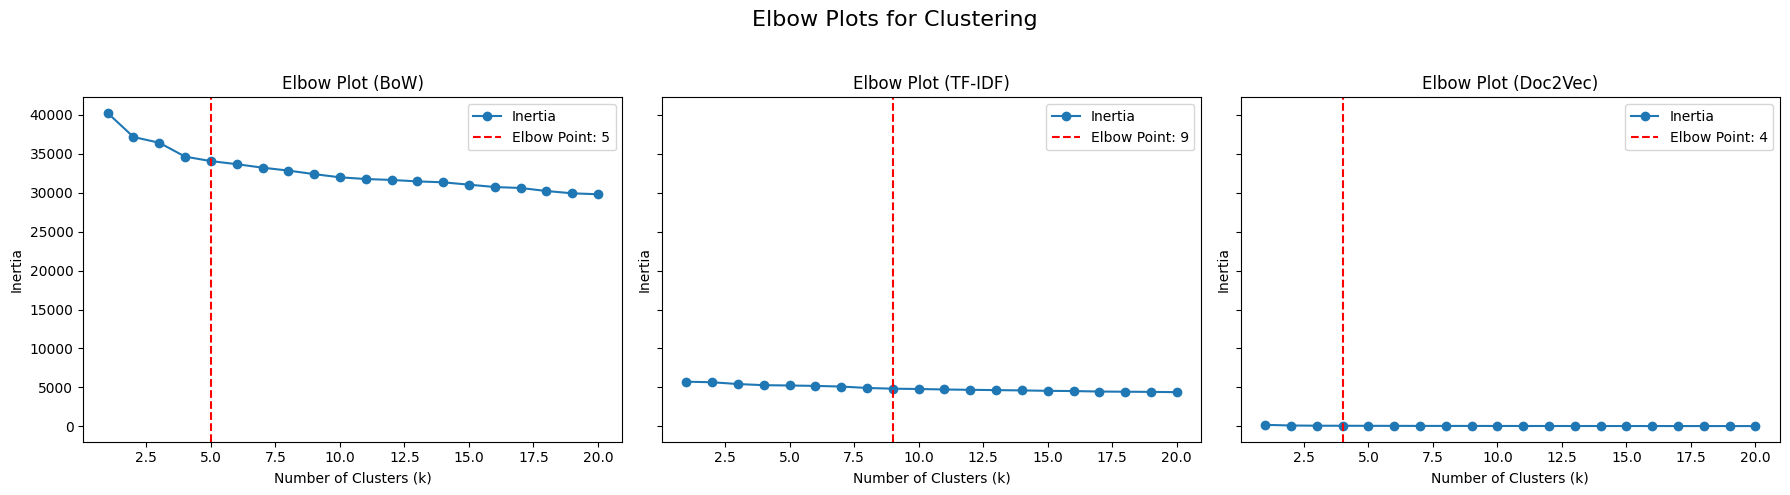

In [32]:
bow_elbow,tfidf_elbow,doc2vec_elbow = combined_elbow_plot(ner_bow_td_matrix,ner_tfidf_td_matrix,ner_doc2vec_td_matrix)

Computing and comparing the inertia of each K-means optimal implementation

In [33]:
kmeans_doc2vec = KMeans(n_clusters= doc2vec_elbow, random_state=42).fit(ner_doc2vec_td_matrix)
kmeans_tfidf = KMeans(n_clusters=tfidf_elbow, random_state=42).fit(ner_tfidf_td_matrix)
kmeans_bow = KMeans(n_clusters=bow_elbow, random_state=42).fit(ner_bow_td_matrix)



In [34]:
model_list = [("kmeans tfidf k=9", kmeans_tfidf, ner_tfidf_td_matrix),
              ("kmeans BoW k=9", kmeans_bow, ner_bow_td_matrix),
              ("kmeans Doc2Vec k=9", kmeans_doc2vec, ner_doc2vec_td_matrix)]

def unsupervised_score_calculator(model_list):
    for tuple in model_list:
        #Inertia
        print("Inertia of {}: {}".format(tuple[0],tuple[1].inertia_))
        #Silhouette Score
        print("Silhouette score of {}: {}".format(tuple[0],silhouette_score(tuple[2],tuple[1].labels_)))
        #calinski-harabasz
        print("Calinski-Harabasz score of {}: {}".format(tuple[0],calinski_harabasz_score(tuple[2],tuple[1].labels_)))
        print("\n")

In [35]:
unsupervised_score_calculator(model_list)

Inertia of kmeans tfidf k=9: 4890.754904448525
Silhouette score of kmeans tfidf k=9: 0.07521891136792502
Calinski-Harabasz score of kmeans tfidf k=9: 127.65675284471094


Inertia of kmeans BoW k=9: 35404.185078345894
Silhouette score of kmeans BoW k=9: 0.032028127095609864
Calinski-Harabasz score of kmeans BoW k=9: 201.39045289537336


Inertia of kmeans Doc2Vec k=9: 79.10781408880305
Silhouette score of kmeans Doc2Vec k=9: 0.25197881824223645
Calinski-Harabasz score of kmeans Doc2Vec k=9: 3019.713847234875




Doc2Vec seems to produce, by far, the best model. As such, we'll try to visualize the produced clusters.

But first, we must name the clusters for easier identification

In [36]:
reviews["kmeans_doc2vec_clusters"] = kmeans_doc2vec.labels_.tolist()

C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\2425393033.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:

def cluster_namer(dataset, label_column_name, nr_words=5):
    labels = list(set(dataset[label_column_name]))
    # corpus generator
    corpus = []
    for label in labels:
        label_doc = ""
        for doc in dataset["filtered_review"].loc[dataset[label_column_name] == label]:        
            if isinstance(doc, list):
                # If the document is a list of tokens, join them into a string
                doc = " ".join(doc)
            label_doc = label_doc + " " + doc
        corpus.append(label_doc)
    # Use CountVectorizer for BoW representation
    bow_vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
    label_name_list = []

    for idx, document in enumerate(corpus):
        corpus_bow_td_matrix = bow_vectorizer.fit_transform(corpus)
        corpus_bow_word_list = bow_vectorizer.get_feature_names_out()

        label_vocabulary = p.word_freq_calculator(corpus_bow_td_matrix[idx].toarray(), \
                                                corpus_bow_word_list, df_output=True)
        
        label_vocabulary = label_vocabulary.head(nr_words)
        label_name = ""
        for jdx in range(len(label_vocabulary)):
            label_name = label_name + "_" + label_vocabulary["words"].iloc[jdx]

        label_name_list.append(label_name)

    label_name_dict = dict(zip(labels, label_name_list))
    dataset[label_column_name] = dataset[label_column_name].map(lambda label: label_name_dict[label])

    return dataset

In [38]:
reviews = cluster_namer(reviews, "kmeans_doc2vec_clusters")

C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\3744300970.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
reviews

,Review,Cuisines,review_clean,filtered_review,bow_vector,tfidf_vector,doc2vec_vector,kmeans_doc2vec_clusters
0,"The ambience was good, food was quite good . h...","Chinese, Continental, Kebab, European, South I...",the ambience was good food was quite good had...,[brunch],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.003989324439316988, 0.03702827915549278, -...",_chicken_chocolate_fish_rice_starters
4,Food is good.we ordered Kodi drumsticks and ba...,"Chinese, Continental, Kebab, European, South I...",food is ordered kodi drumsticks and basket mu...,"[drumsticks, mutton, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0028016415890306234, 0.03027438558638096, ...",_chicken_starters_rice_buffet_veg
7,Well after reading so many reviews finally vis...,"Chinese, Continental, Kebab, European, South I...",well after reading so many reviews finally vis...,"[corn, fish, biryani]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0022620437666773796, 0.018668174743652344,...",_chicken_starters_rice_veg_biryani
8,"Excellent food , specially if you like spicy f...","Chinese, Continental, Kebab, European, South I...",excellent food specially if you like spicy fo...,[dinners],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00045780063373968005, 0.03700072318315506,...",_chicken_chocolate_fish_rice_starters
9,Came for the birthday treat of a close friend....,"Chinese, Continental, Kebab, European, South I...",came for the birthday treat of a close friend ...,"[treat, treat]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002557068830356002, 0.026093028485774994, ...",_chicken_starters_rice_buffet_veg
...,...,...,...,...,...,...,...,...
9949,Chinese Pavilion in Banjara HIlls was the firs...,"Chinese, Seafood",chinese pavilion in banjara hills was the firs...,"[noodles, rice, lamb, brownie, rice]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.004669062793254852, 0.009531279094517231, -...",_chicken_starters_veg_rice_buffet
9950,Madhumathi Mahajan Well to start with nice cou...,"Chinese, Seafood",madhumathi mahajan well to start with nice cou...,"[spinach, meal, salad, cabbage, dressing, cabb...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005220507271587849, 0.015982797369360924, -...",_chicken_starters_rice_veg_biryani
9951,This place has never disappointed us.. The foo...,"Chinese, Seafood",this place has never disappointed us the food ...,"[rice, oil, fish, noodles, chicken]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.002341720275580883, 0.017672954127192497, ...",_chicken_starters_rice_veg_biryani
9952,"Bad rating is mainly because of ""Chicken Bone ...","Chinese, Seafood",bad rating is mainly because of chicken bone f...,"[chicken, veg, luncheon, tables, veg, soup, sp...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00254703382961452, 0.030191998928785324, -0...",_chicken_starters_rice_buffet_veg


C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\3279838669.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




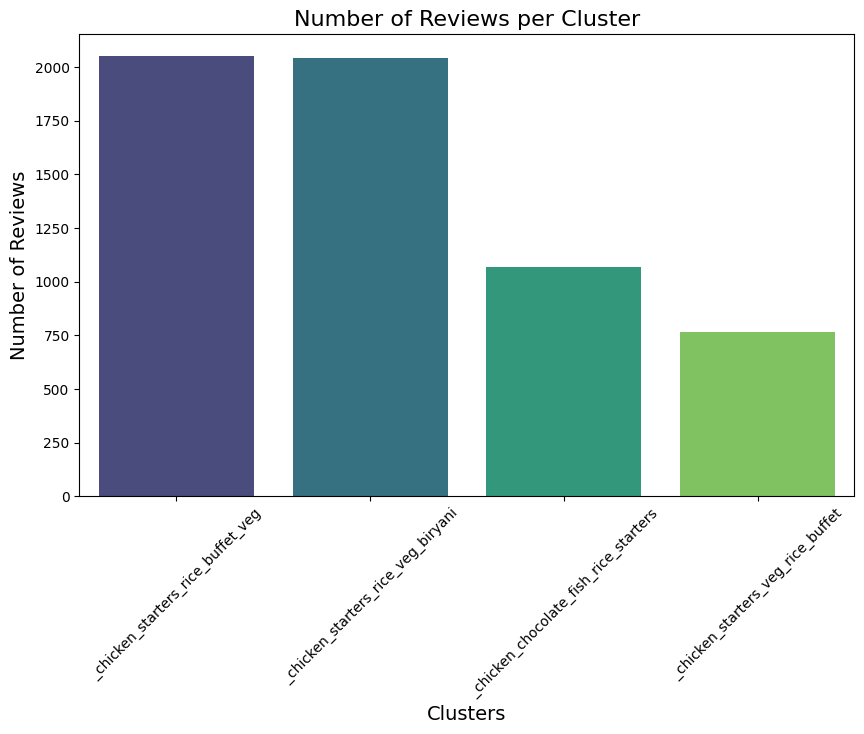

In [40]:
cluster_counts = reviews["kmeans_doc2vec_clusters"].value_counts()
    # Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Number of Reviews per Cluster", fontsize=16)
plt.xlabel("Clusters", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(rotation=45)
plt.show()

### Trying HDBScan

In [41]:
hdbscan = HDBSCAN(min_cluster_size=20).fit(ner_bow_td_matrix)
reviews["hdbscan_bow_clusters"] = hdbscan.labels_.tolist()

reviews = cluster_namer(reviews, "hdbscan_bow_clusters")


C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\2194706177.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\3744300970.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\4127520812.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




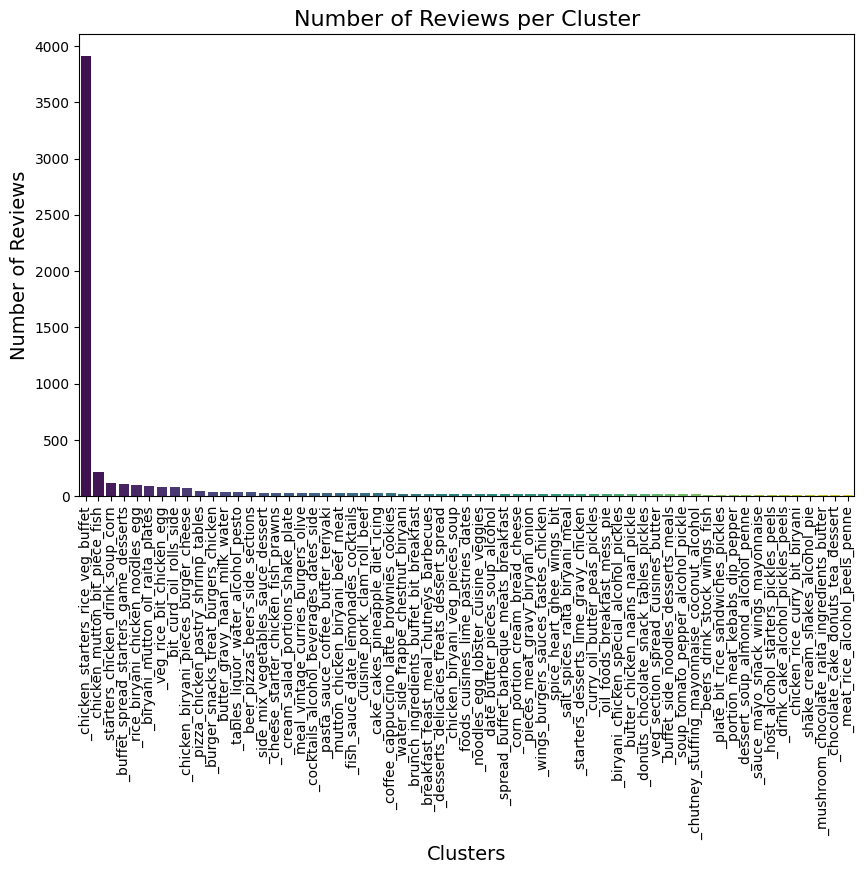

In [42]:
cluster_counts = reviews["hdbscan_bow_clusters"].value_counts()
    # Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Number of Reviews per Cluster", fontsize=16)
plt.xlabel("Clusters", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(rotation=90)
plt.show()

### Trying Optics

In [ ]:
optics = OPTICS(metric="minkowski",min_samples=10).fit(ner_bow_td_matrix)
reviews["optics_bow_clusters"] = optics.labels_.tolist()

reviews = cluster_namer(reviews, "optics_bow_clusters")

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning:

divide by zero encountered in divide

C:\Users\pedro\AppData\Local\Temp\ipykernel_17432\674792884.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\pedro\AppData\Local\Temp\ipykernel_19040\3223078177.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




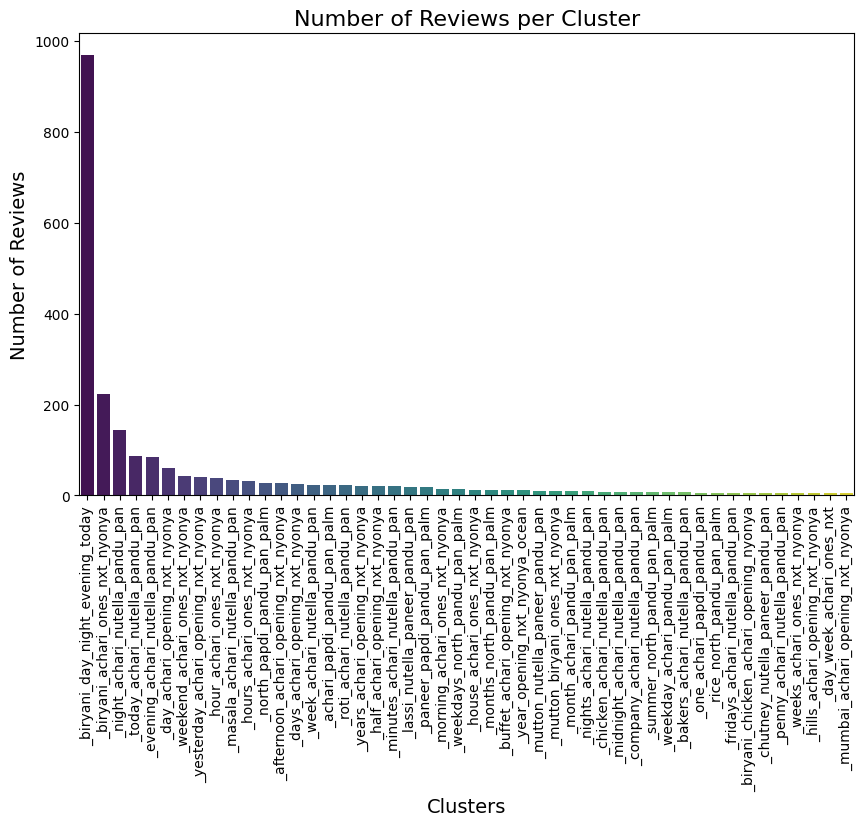

In [119]:
cluster_counts = reviews["optics_bow_clusters"].value_counts()
    # Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Number of Reviews per Cluster", fontsize=16)
plt.xlabel("Clusters", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)
plt.xticks(rotation=90)
plt.show()